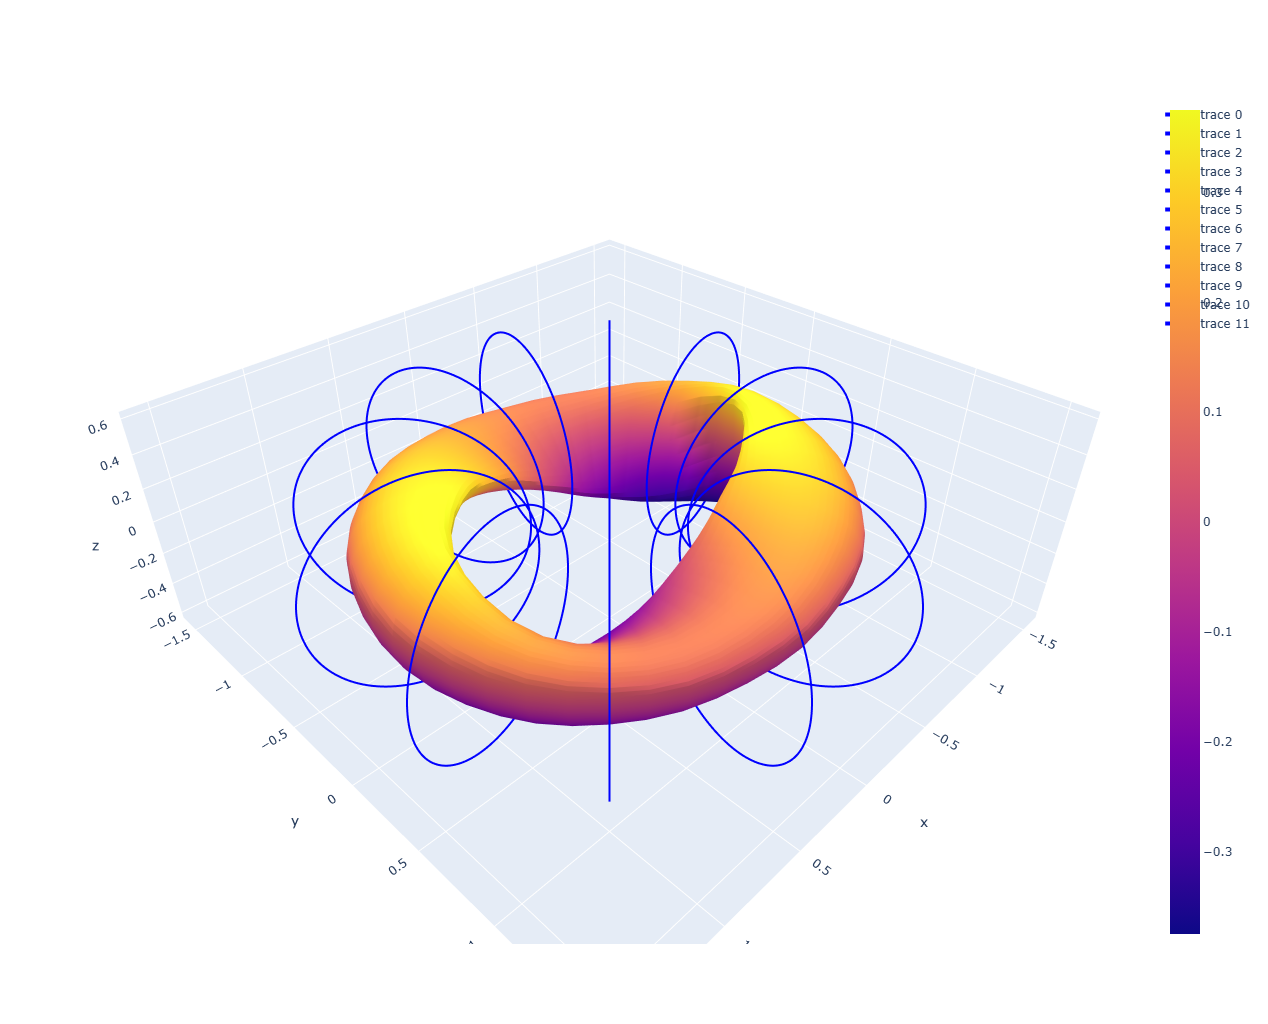

Initial max|B dot n|: 0.26125535217141904


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from simsopt._core import load
from simsopt.geo import plot, MeanSquaredCurvature, CurveSurfaceDistance, CurveCurveDistance, LpCurveCurvature
from simsopt.geo import SurfaceRZFourier, create_equally_spaced_curves, \
    CurveLength, curves_to_vtk, CurveCWSFourier, ArclengthVariation
from simsopt.field import Current, coils_via_symmetries, BiotSavart
from simsopt.objectives import SquaredFlux, QuadraticPenalty
from scipy.optimize import minimize

res = load(f'serial0021326.json')

MAXITER = 200
quadpoints = 300
USE_PRESIM = False
USE_CWS = True

major_R = 1
minor_r = 0.5 #parameter search
ncoils = 3
order = 3
nfp_coils = 1
current_0  = 1
current_mult = 1e5
FIX_ONE_CURRENT = True



nphi = 48
ntheta = 48
s = SurfaceRZFourier.from_vmec_input('input', range="full torus", nphi=nphi, ntheta=ntheta)

##creating coils and currents:
#if USE_PRESIM:
#    coils_presim = res[1]
#    surface = res[0][-1]
#    base_curves = [x.curve for x in coils_presim]
#    base_currents = [x.current for x in coils_presim]
#    base_currents[0].fix_all()
#else:
#    base_curves = create_equally_spaced_curves(ncoils, s.nfp, stellsym=True, R0=1, R1=0.6, order=order)
#    base_currents = [Current(current_0) for i in range(ncoils)]
#    if FIX_ONE_CURRENT:
#        base_currents[0].fix_all()

if USE_CWS:
    theta_linspace = np.linspace(0, 1, ntheta, endpoint=True)
    phi_linspace = np.linspace(0, 1, nphi, endpoint=True)
    # currently don't know what this does, most likely only extension away from plasma
    # this could be necessary if the CWS is more complicated and is generated from a stage I 
    # ext_via_normal_factor = 0.2565
    #ext_via_normal_factor = 0.1482   
    #cws.extend_via_normal(ext_via_normal_factor)
    #0.25216216216216214
    # CREATE COIL WINDING SURFACE SURFACE
    cws = SurfaceRZFourier(nfp=nfp_coils,stellsym=True)
    cws.set_rc(0,0,major_R)
    cws.set_rc(major_R,0,minor_r+0.1)
    cws.set_zs(major_R,0,minor_r+0.1)

    # CREATE CURVES + COILS     
    base_curves = []
    for i in range(ncoils):
        curve_cws = CurveCWSFourier(
            mpol=cws.mpol,
            ntor=cws.ntor,
            idofs=cws.x,
            quadpoints=quadpoints,
            order=order,
            nfp=nfp_coils,
            stellsym=cws.stellsym,
        )
        angle = (i + 0.5)*(2 * np.pi)/((2) * s.nfp * ncoils)
        curve_dofs = np.zeros(len(curve_cws.get_dofs()),)
        curve_dofs[0] = 1
        curve_dofs[2*order+2] = 0
        curve_dofs[2*order+3] = angle
        curve_cws.set_dofs(curve_dofs)
        curve_cws.fix(0)
        curve_cws.fix(2*order+2)
        base_curves.append(curve_cws)
    base_currents = [Current(current_0)*current_mult for i in range(ncoils)]
    if FIX_ONE_CURRENT:
        base_currents[0].fix_all()
   


coils = coils_via_symmetries(base_curves, base_currents, nfp_coils*2, True)
curves = [c.curve for c in coils]

fig = plot(coils + [s] , engine="plotly", close=True, show=False)
fig.update_layout(
    autosize=False,
    width=1024,
    height=1024,)
fig.show()

bs = BiotSavart(coils)
bs.set_points(s.gamma().reshape((-1, 3)))

B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
print('Initial max|B dot n|:', np.max(np.abs(B_dot_n)))


In [2]:
##calculating magnetic field from coils:

# another init values from repo
# LENGTH_THRESHOLD = 20
# LENGTH_WEIGHT = 1e-8
# CC_THRESHOLD = 0.1
# CC_WEIGHT = 100
# CURVATURE_THRESHOLD = 60
# CURVATURE_WEIGHT = 1e-5
# MSC_THRESHOLD = 20
# MSC_WEIGHT = 1e-9
# ARCLENGTH_WEIGHT = 3e-8
# LENGTH_CON_WEIGHT = 0.1
# MAXITER = 50


FLUX_WEIGHT = 1

##setting up parameters for penalty function:
# Threshold and weight for the maximum length of each individual coil:
#LENGTH_THRESHOLD = 20
#LENGTH_WEIGHT = 1e-8

LENGTH_THRESHOLD = 20  
LENGTH_WEIGHT = 1e-8


# Threshold and weight for the coil-to-coil distance penalty in the objective function:
#CC_THRESHOLD = 0.1
#CC_WEIGHT = 100

CC_THRESHOLD = 0.2
CC_WEIGHT = 100


# Threshold and weight for the curvature penalty in the objective function:
#CURVATURE_THRESHOLD = 60
#CURVATURE_WEIGHT = 1e-5

CURVATURE_THRESHOLD = 20
CURVATURE_WEIGHT = 1e-2


# Threshold and weight for the mean squared curvature penalty in the objective function:
#MSC_THRESHOLD = 60
#MSC_WEIGHT = 1e-9
#ARCLENGTH_WEIGHT = 3e-8
#LENGTH_CON_WEIGHT = 0.1

MSC_THRESHOLD = 60
MSC_WEIGHT = 1e-9
ARCLENGTH_WEIGHT = 3e-8
LENGTH_CON_WEIGHT = 0.1

LENGTH_THRESHOLD = 20
LENGTH_WEIGHT = 1e-8
CC_THRESHOLD = 0.1
CC_WEIGHT = 100
CURVATURE_THRESHOLD = 60
CURVATURE_WEIGHT = 1e-5
MSC_THRESHOLD = 20
MSC_WEIGHT = 1e-9
ARCLENGTH_WEIGHT = 3e-8
LENGTH_CON_WEIGHT = 0.1

Jf = FLUX_WEIGHT * SquaredFlux(s, bs, definition="local")
Jls = [CurveLength(c) for c in base_curves]
Jccdist = CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=len(curves))
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for i, c in enumerate(base_curves)]
Jmscs = [MeanSquaredCurvature(c) for c in base_curves]
Jals = [ArclengthVariation(c) for c in base_curves]
J_LENGTH = LENGTH_WEIGHT * sum(Jls)
J_CC = CC_WEIGHT * Jccdist
J_CURVATURE = CURVATURE_WEIGHT * sum(Jcs)
J_MSC = MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD, f="max") for i, J in enumerate(Jmscs))
J_ALS = ARCLENGTH_WEIGHT * sum(Jals)
J_LENGTH_PENALTY = LENGTH_CON_WEIGHT * sum([QuadraticPenalty(Jls[i], LENGTH_THRESHOLD, f="max") for i in range(len(base_curves))])
JF = Jf + J_LENGTH


B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)

print('Initial max|B dot n|:', np.max(np.abs(B_dot_n)))



def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    outstr = f"J={J:.3e}, Jf={jf:.3e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}"
    print(outstr)
    return J, grad
    

print("""
################################################################################
### Perform a Taylor test ######################################################
################################################################################
""")
f = fun
dofs = JF.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
for eps in [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    print("err", (J1-J2)/(2*eps) - dJh)

print("""
################################################################################
### Run the optimisation #######################################################
################################################################################
""")

B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
B_dot_n_max = np.max(np.abs(B_dot_n)).copy()

total_curve_length_start = sum(func.J() for func in Jls).copy()


res = minimize(fun, dofs, jac=True, method='L-BFGS-B',
               options={'maxiter': MAXITER, 'maxcor': 500, 'iprint': 5}, tol=1e-10)

B_dot_n = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
print('starting max|B dot n|:', B_dot_n_max)
print('Final max|B dot n|:', np.max(np.abs(B_dot_n)))
total_curve_length = sum(func.J() for func in Jls)
print("starting Sum of lengths of base curves:", total_curve_length_start)
print("Sum of lengths of base curves:", total_curve_length)

Initial max|B dot n|: 0.26125535217141904

################################################################################
### Perform a Taylor test ######################################################
################################################################################

J=2.593e-01, Jf=2.593e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
J=2.594e-01, Jf=2.594e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
J=2.593e-01, Jf=2.593e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
err 2.110802327565109e-06
J=2.593e-01, Jf=2.593e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
J=2.593e-01, Jf=2.593e-01, ⟨B·n⟩=4.7e-02, Len=sum([3.8, 3.8, 3.8])=11.3, ϰ=[1.7, 1.7, 1.7], ∫ϰ²/L=[2.8, 2.8, 2.8], C-C-Sep=0.21
err 2.1124979737718874e-08
J=2.593e-01, Jf=2.59

 This problem is unconstrained.


J=6.648e-02, Jf=6.648e-02, ⟨B·n⟩=2.1e-02, Len=sum([4.5, 4.7, 5.2])=14.4, ϰ=[12.4, 9.2, 8.9], ∫ϰ²/L=[6.1, 7.0, 9.5], C-C-Sep=0.00

At iterate    5    f=  6.64813D-02    |proj g|=  8.19057D-02
J=5.214e-02, Jf=5.214e-02, ⟨B·n⟩=1.8e-02, Len=sum([4.8, 4.8, 6.2])=15.8, ϰ=[26.9, 10.2, 12.0], ∫ϰ²/L=[9.6, 7.0, 12.1], C-C-Sep=0.00
J=5.959e-02, Jf=5.959e-02, ⟨B·n⟩=2.0e-02, Len=sum([5.5, 5.8, 8.2])=19.5, ϰ=[166.7, 12.4, 26.5], ∫ϰ²/L=[44.1, 8.7, 16.8], C-C-Sep=0.00
J=4.741e-02, Jf=4.741e-02, ⟨B·n⟩=1.8e-02, Len=sum([5.0, 5.0, 6.7])=16.7, ϰ=[38.9, 10.9, 14.0], ∫ϰ²/L=[12.6, 7.5, 13.5], C-C-Sep=0.00
J=5.648e-02, Jf=5.648e-02, ⟨B·n⟩=1.9e-02, Len=sum([5.7, 5.9, 8.7])=20.2, ϰ=[283.3, 14.2, 30.7], ∫ϰ²/L=[69.7, 9.3, 17.6], C-C-Sep=0.00
J=4.586e-02, Jf=4.586e-02, ⟨B·n⟩=1.7e-02, Len=sum([5.1, 5.2, 7.0])=17.3, ϰ=[49.9, 11.5, 16.2], ∫ϰ²/L=[15.5, 7.8, 14.3], C-C-Sep=0.00
J=4.841e-02, Jf=4.841e-02, ⟨B·n⟩=1.8e-02, Len=sum([5.5, 5.6, 8.1])=19.2, ϰ=[134.3, 13.2, 25.0], ∫ϰ²/L=[35.9, 8.8, 16.5], C-C-Sep=0.00
J=4.540e-


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=4.364e-02, Jf=4.364e-02, ⟨B·n⟩=1.6e-02, Len=sum([5.2, 5.4, 7.8])=18.4, ϰ=[44.8, 11.8, 23.4], ∫ϰ²/L=[14.8, 8.1, 16.7], C-C-Sep=0.00
J=3.808e-02, Jf=3.808e-02, ⟨B·n⟩=1.6e-02, Len=sum([5.3, 5.4, 7.9])=18.6, ϰ=[45.6, 11.3, 25.4], ∫ϰ²/L=[14.9, 7.9, 17.2], C-C-Sep=0.00

At iterate   15    f=  3.80780D-02    |proj g|=  4.73743D-02
J=3.642e-02, Jf=3.642e-02, ⟨B·n⟩=1.6e-02, Len=sum([5.3, 5.5, 8.0])=18.8, ϰ=[41.1, 10.7, 29.9], ∫ϰ²/L=[14.0, 7.6, 18.5], C-C-Sep=0.00
J=3.532e-02, Jf=3.532e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.4, 5.6, 8.2])=19.2, ϰ=[35.7, 10.0, 40.7], ∫ϰ²/L=[13.2, 7.3, 21.3], C-C-Sep=0.00
J=3.574e-02, Jf=3.574e-02, ⟨B·n⟩=1.6e-02, Len=sum([5.4, 6.0, 8.6])=20.0, ϰ=[34.7, 11.7, 103.6], ∫ϰ²/L=[13.6, 7.5, 34.3], C-C-Sep=0.00
J=3.447e-02, Jf=3.447e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.4, 5.7, 8.3])=19.4, ϰ=[35.5, 9.7, 50.3], ∫ϰ²/L=[13.3, 7.2, 23.4], C-C-Sep=0.00
J=5.067e-02, Jf=5.067e-02, ⟨B·n⟩=2.0e-02, Len=sum([5.6, 6.5, 9.5])=21.6, ϰ=[39.9, 31.3, 2085.3], ∫ϰ²/L=[17.2, 12.1, 484.8], C-C-Sep=0.00
J=3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.944e-02, Jf=2.944e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.8, 5.9, 9.8])=21.4, ϰ=[285.4, 11.6, 689.5], ∫ϰ²/L=[82.8, 7.6, 199.2], C-C-Sep=0.00
J=6.385e-02, Jf=6.385e-02, ⟨B·n⟩=2.4e-02, Len=sum([7.2, 6.1, 11.9])=25.2, ϰ=[54.9, 21.1, 221.6], ∫ϰ²/L=[17.1, 11.0, 69.9], C-C-Sep=0.00
J=2.933e-02, Jf=2.933e-02, ⟨B·n⟩=1.5e-02, Len=sum([5.9, 5.9, 9.9])=21.7, ϰ=[124.2, 11.0, 507.4], ∫ϰ²/L=[43.5, 7.8, 162.1], C-C-Sep=0.00
J=5.909e-02, Jf=5.909e-02, ⟨B·n⟩=2.2e-02, Len=sum([7.2, 6.2, 12.3])=25.6, ϰ=[77.5, 22.3, 322.9], ∫ϰ²/L=[21.1, 11.0, 86.3], C-C-Sep=0.00
J=2.912e-02, Jf=2.912e-02, ⟨B·n⟩=1.5e-02, Len=sum([6.0, 5.9, 10.1])=22.0, ϰ=[78.8, 10.7, 499.8], ∫ϰ²/L=[31.4, 8.0, 142.4], C-C-Sep=0.00
J=3.774e-02, Jf=3.774e-02, ⟨B·n⟩=1.8e-02, Len=sum([6.8, 6.0, 11.4])=24.2, ϰ=[31.1, 17.1, 358.3], ∫ϰ²/L=[15.0, 9.7, 92.3], C-C-Sep=0.00
J=2.907e-02, Jf=2.907e-02, ⟨B·n⟩=1.5e-02, Len=sum([6.1, 5.9, 10.3])=22.2, ϰ=[57.1, 10.7, 444.2], ∫ϰ²/L=[25.2, 8.1, 127.6], C-C-Sep=0.00
J=3.216e-02, Jf=3.216e-02, ⟨B·n⟩=1.6e-02, Len=sum


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.735e-02, Jf=2.735e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.7])=23.1, ϰ=[37.2, 13.0, 224.0], ∫ϰ²/L=[20.3, 7.9, 79.8], C-C-Sep=0.00

At iterate   65    f=  2.73485D-02    |proj g|=  4.02345D-02
J=2.783e-02, Jf=2.783e-02, ⟨B·n⟩=1.5e-02, Len=sum([6.2, 6.3, 10.9])=23.4, ϰ=[34.2, 15.6, 302.6], ∫ϰ²/L=[21.0, 8.0, 87.2], C-C-Sep=0.00
J=2.720e-02, Jf=2.720e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.8])=23.2, ϰ=[36.6, 13.5, 209.7], ∫ϰ²/L=[20.4, 7.9, 79.8], C-C-Sep=0.00
J=2.741e-02, Jf=2.741e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[35.0, 14.8, 253.7], ∫ϰ²/L=[20.8, 7.9, 82.8], C-C-Sep=0.00
J=2.718e-02, Jf=2.718e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.8])=23.2, ϰ=[36.2, 13.8, 203.3], ∫ϰ²/L=[20.5, 7.9, 80.0], C-C-Sep=0.00
J=3.591e-02, Jf=3.591e-02, ⟨B·n⟩=1.8e-02, Len=sum([6.2, 6.6, 11.4])=24.2, ϰ=[60.6, 28.1, 32971.5], ∫ϰ²/L=[30.3, 11.3, 20752.9], C-C-Sep=0.00
J=2.697e-02, Jf=2.697e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[33.3, 15.2, 266.9], ∫ϰ²/L=[20.9, 8.0, 83.7], 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.549e-02, Jf=2.549e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.1, 10.9])=23.2, ϰ=[27.5, 14.8, 351.2], ∫ϰ²/L=[22.3, 8.3, 96.4], C-C-Sep=0.00
J=2.486e-02, Jf=2.486e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[23.9, 15.2, 253.3], ∫ϰ²/L=[21.7, 8.2, 89.8], C-C-Sep=0.00
J=2.515e-02, Jf=2.515e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.1, 10.9])=23.2, ϰ=[26.1, 15.0, 317.6], ∫ϰ²/L=[22.0, 8.3, 93.5], C-C-Sep=0.00
J=2.488e-02, Jf=2.488e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.1, 15.1, 265.3], ∫ϰ²/L=[21.8, 8.2, 90.3], C-C-Sep=0.00
J=2.486e-02, Jf=2.486e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.0, 15.2, 255.7], ∫ϰ²/L=[21.7, 8.2, 89.9], C-C-Sep=0.00
J=2.486e-02, Jf=2.486e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[23.9, 15.2, 253.3], ∫ϰ²/L=[21.7, 8.2, 89.8], C-C-Sep=0.00

At iterate   70    f=  2.48624D-02    |proj g|=  3.40879D-02
J=3.174e-02, Jf=3.174e-02, ⟨B·n⟩=1.7e-02, Len=sum([6.3, 6.2, 10.9])=23.4, ϰ=[57.9, 14.3, 812.3], ∫ϰ²/L=[31.2, 8.8, 170.2], C-C-S


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.480e-02, Jf=2.480e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.5, 15.3, 282.0], ∫ϰ²/L=[21.3, 8.2, 90.8], C-C-Sep=0.00
J=2.480e-02, Jf=2.480e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.4, 15.3, 277.9], ∫ϰ²/L=[21.4, 8.2, 90.6], C-C-Sep=0.00
J=2.480e-02, Jf=2.480e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.4, 15.3, 277.0], ∫ϰ²/L=[21.4, 8.2, 90.6], C-C-Sep=0.00
J=2.480e-02, Jf=2.480e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.4, 15.3, 276.9], ∫ϰ²/L=[21.4, 8.2, 90.6], C-C-Sep=0.00
J=2.480e-02, Jf=2.480e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.4, 15.3, 276.8], ∫ϰ²/L=[21.4, 8.2, 90.6], C-C-Sep=0.00
J=2.480e-02, Jf=2.480e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.4, 15.3, 276.8], ∫ϰ²/L=[21.4, 8.2, 90.6], C-C-Sep=0.00
J=2.480e-02, Jf=2.480e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.2, ϰ=[24.4, 15.3, 276.8], ∫ϰ²/L=[21.4, 8.2, 90.6], C-C-Sep=0.00
J=2.480e-02, Jf=2.480e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2,


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.653e-02, Jf=2.653e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.1, 6.3, 10.9])=23.3, ϰ=[31.3, 15.5, 532.1], ∫ϰ²/L=[23.1, 8.1, 116.9], C-C-Sep=0.00
J=2.475e-02, Jf=2.474e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.5, 15.3, 314.7], ∫ϰ²/L=[21.6, 8.2, 92.9], C-C-Sep=0.00
J=2.678e-02, Jf=2.677e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.4, 11.0])=23.5, ϰ=[36.5, 15.9, 720.3], ∫ϰ²/L=[24.4, 8.2, 147.9], C-C-Sep=0.00
J=2.482e-02, Jf=2.482e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[25.3, 15.4, 389.9], ∫ϰ²/L=[21.9, 8.2, 99.1], C-C-Sep=0.00
J=2.475e-02, Jf=2.475e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.6, 15.3, 328.7], ∫ϰ²/L=[21.6, 8.2, 93.9], C-C-Sep=0.00
J=2.475e-02, Jf=2.475e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.5, 15.3, 317.6], ∫ϰ²/L=[21.6, 8.2, 93.1], C-C-Sep=0.00
J=2.475e-02, Jf=2.475e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.5, 15.3, 315.3], ∫ϰ²/L=[21.6, 8.2, 93.0], C-C-Sep=0.00
J=2.475e-02, Jf=2.474e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.6, 15.3, 321.3], ∫ϰ²/L=[21.6, 8.2, 93.3], C-C-Sep=0.00
J=2.474e-02, Jf=2.474e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.8, 15.4, 337.0], ∫ϰ²/L=[21.5, 8.2, 94.3], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.6, 15.3, 324.6], ∫ϰ²/L=[21.6, 8.2, 93.5], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.7, 15.3, 332.8], ∫ϰ²/L=[21.5, 8.2, 94.0], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.8, 15.4, 335.6], ∫ϰ²/L=[21.5, 8.2, 94.2], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.7, 15.3, 333.3], ∫ϰ²/L=[21.5, 8.2, 94.1], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[24.7, 15.3, 332.8], ∫ϰ²/L=[21.5, 8.2, 94.0], C-C-Sep=0.00
J=3.345e-02, Jf=3.345e-02, ⟨B·n⟩=1.5e-02, Len=sum([6.4,


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[25.3, 15.5, 410.6], ∫ϰ²/L=[21.8, 8.2, 101.0], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[25.0, 15.4, 382.2], ∫ϰ²/L=[21.7, 8.2, 98.1], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[25.0, 15.4, 376.4], ∫ϰ²/L=[21.7, 8.2, 97.6], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[25.0, 15.4, 374.9], ∫ϰ²/L=[21.7, 8.2, 97.5], C-C-Sep=0.00
  ys=-5.671E-06  -gs= 1.041E-03 BFGS update SKIPPED
J=2.479e-02, Jf=2.479e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.3, 10.9])=23.4, ϰ=[30.1, 15.8, 568.8], ∫ϰ²/L=[22.8, 8.3, 122.3], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[25.6, 15.5, 418.6], ∫ϰ²/L=[21.9, 8.2, 101.8], C-C-Sep=0.00
J=2.473e-02, Jf=2.473e-02, ⟨B·n⟩=1.4e-02, Len=sum([6.2, 6.2, 10.9])=23.3, ϰ=[25.0, 15.4, 383.9], ∫ϰ²/L=[21.7, 8.2, 98.3], C-C-Sep=0.00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [3]:
from simsopt._core import save

save(bs,'2_bs_opt.json')
save(bs.coils,'2_coils_opt.json')

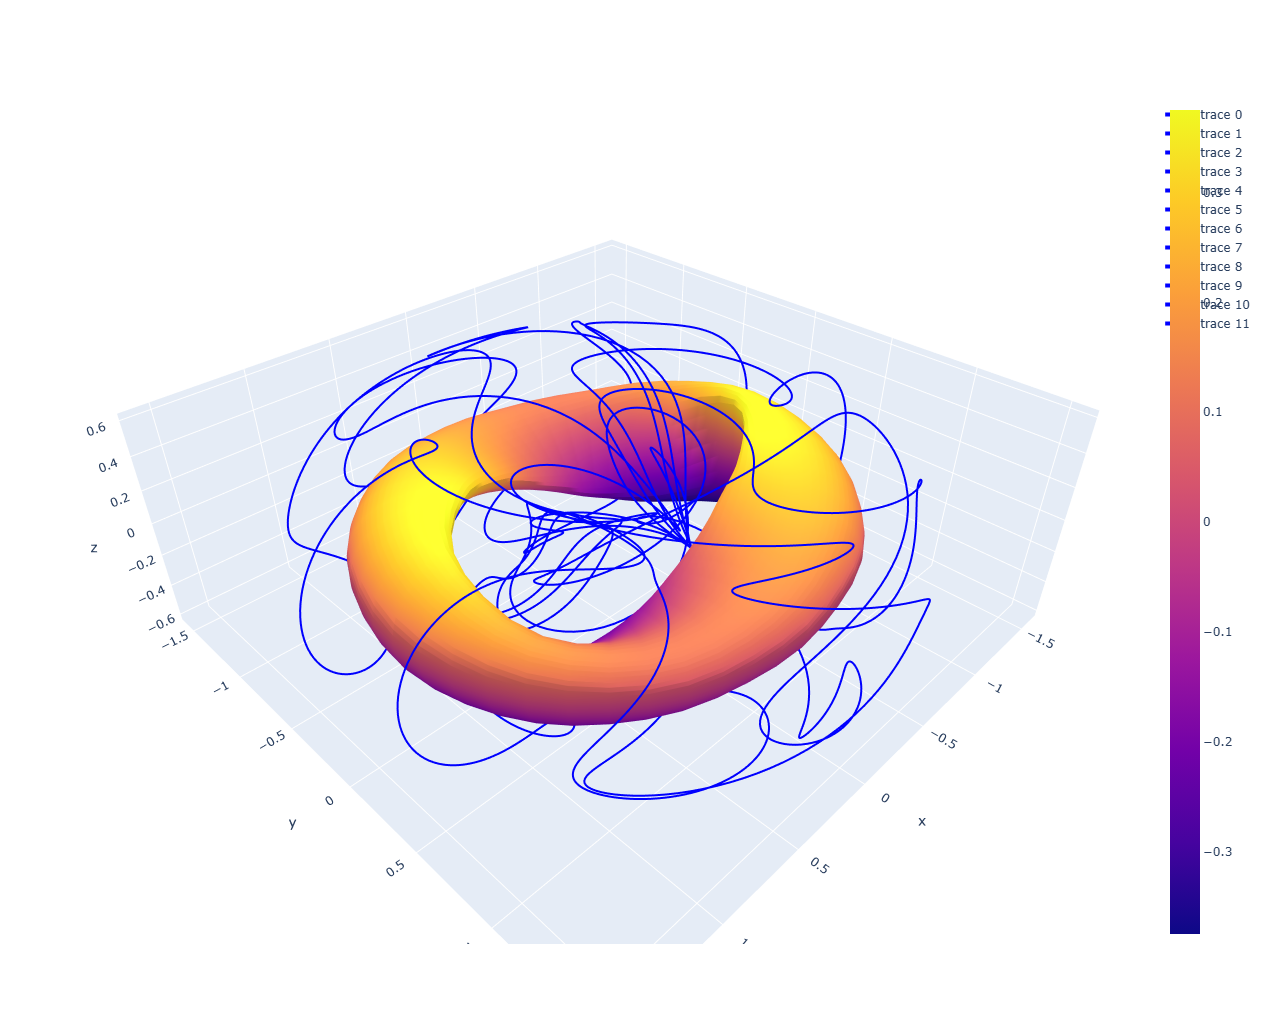

In [4]:
#fig = plot(coils + [s] + [cws], engine="plotly", close=True, show=False)
fig = plot(coils + [s] , engine="plotly", close=True, show=False)
fig.update_layout(
    autosize=False,
    width=1024,
    height=1024,)
fig.show()

In [5]:
from simsopt.field.magneticfieldclasses import InterpolatedField
import os

def make_Bnormal_plots(bs, s_plot, out_dir='', bs_filename="Bnormal"):
    """
    Plot Bnormal on plasma surface from a MagneticField object.
    Do this quite a bit in the permanent magnet optimization
    and initialization so this is a wrapper function to reduce
    the amount of code.

    Args:
        bs: MagneticField class object.
        s_plot: plasma boundary surface with range = 'full torus'.
        out_dir: Path or string for the output directory for saved files.
        bs_filename: String denoting the name of the output file. 
    """
    nphi = len(s_plot.quadpoints_phi)
    ntheta = len(s_plot.quadpoints_theta)
    bs.set_points(s_plot.gamma().reshape((-1, 3)))
    pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s_plot.unitnormal(), axis=2)[:, :, None]}
    s_plot.to_vtk(out_dir + bs_filename, extra_data=pointData)

def trace_fieldlines(bfield, label, s, out_dir=''):
    """
    Make Poincare plots on a surface as in the trace_fieldlines
    example in the examples/1_Simple/ directory.

    Args:
        bfield: MagneticField or InterpolatedField class object.
        label: Name of the file to write to.
        s: plasma boundary surface.
        out_dir: Path or string for the output directory for saved files.
    """
    from simsopt.field.tracing import compute_fieldlines, \
        plot_poincare_data, \
        IterationStoppingCriterion,LevelsetStoppingCriterion, SurfaceClassifier

    # set fieldline tracer parameters
    nfieldlines = 32
    tmax_fl = 2500
    nplanes = 4

    Z0 = np.zeros(nfieldlines)
    #R0 = np.linspace(s.get_rc(0, 0), s.get_rc(0, 0) + s.get_rc(1, 0) / 4.0, nfieldlines)
    #R0 = np.linspace(s.get_rc(0, 0), s.get_rc(0, 0) + s.get_rc(1, 0) / 2.0, nfieldlines)
    R0 = np.linspace(0.9, 1.4, nfieldlines)
    #Z0 = np.zeros(nfieldlines)
    phis = [(i / 4) * (2 * np.pi / s.nfp) for i in range(nplanes)]

    print("Compute the fieldlines from the initial locations")
    sc_fieldline = SurfaceClassifier(s, h=0.03, p=2)
    #sc_fieldline.to_vtk(str(out_dir) + 'levelset', h=0.02)

    stopping_crit = [LevelsetStoppingCriterion(sc_fieldline.dist)]

    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis,
        stopping_criteria=stopping_crit)

    print("Plotting")
    plot_poincare_data(fieldlines_phi_hits, phis, out_dir + label + '.png', dpi=100, surf=s)


# Directory for output
OUT_DIR = "./poincare/"
os.makedirs(OUT_DIR, exist_ok=True)

# calculating magnetic field from coils:
bs = BiotSavart(coils)


n = 64
rs = np.linalg.norm(s.gamma()[:, :, 0:2], axis=2)
zs = s.gamma()[:, :, 2]
r_margin = 0.05
rrange = (np.min(rs) - r_margin, np.max(rs) + r_margin, n)
phirange = (0, 2 * np.pi / s.nfp, n * 2)
zrange = (0, np.max(zs), n // 2)
degree = 4  # 2 is sufficient sometimes
nphi = len(s.quadpoints_phi)
ntheta = len(s.quadpoints_theta)
bs.set_points(s.gamma().reshape((-1, 3)))
Bnormal = np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)
make_Bnormal_plots(bs, s, OUT_DIR, "2_biot_savart_pre_poincare_check")

print("Interpolating Field")
bsh = InterpolatedField(
    bs , degree, rrange, phirange, zrange, True, nfp=s.nfp, stellsym=s.stellsym
)
bsh.set_points(s.gamma().reshape((-1, 3)))

bsh.to_vtk('poincare/2_CWS_bsh')
trace_fieldlines(bsh, 'poincare_2_CWS', s, OUT_DIR)

Interpolating Field
Compute the fieldlines from the initial locations
Plotting


<Figure size 640x480 with 0 Axes>